In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

#https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
#https://www.ncdc.noaa.gov/cdo-web/datasets

In [2]:
def variables_generales(grupo):
    
    nombre_estacion = grupo['NAME'].tolist()[0]
    latitude_estacion = grupo['LATITUDE'].tolist()[0]
    longitude_estacion = grupo['LONGITUDE'].tolist()[0]
    fecha_menor = grupo['DATE'].min()
    fecha_mayor = grupo['DATE'].max()
    elevacion_estacion = grupo['ELEVATION'].tolist()[0]
                            
    c = ['Nombre','Latitud','Longitud','Elevacion Estacion','Fecha Menor','Fecha Mayor']
    
    variables = pd.Series([nombre_estacion,latitude_estacion,longitude_estacion,
                           elevacion_estacion,fecha_menor,fecha_mayor], 
                     index=c)
    
    return variables

In [3]:
def describir_variables(grupo,variable):
    
    nombre_estacion = grupo['NAME'].tolist()[0]
    dias_con_datos = grupo[variable].count()
    faltantes_precipitacion = len(grupo) - dias_con_datos
    minimo_precipitacion = grupo[variable].min()
    maximo_precipitacion = grupo[variable].max()
    promedio_precipitacion = grupo[variable].mean()
    desviacion_precipitacion = grupo[variable].std()
                            
    c = ['Nombre','Días con datos','Días con datos vacios', 'Minimo', 'Maximo','Promedio','Desviacion']
    
    variables = pd.Series([nombre_estacion,dias_con_datos,faltantes_precipitacion,minimo_precipitacion,
                           maximo_precipitacion,promedio_precipitacion,desviacion_precipitacion], 
                     index=c)
    
    return variables

In [5]:
def plot_estaciones_colombia(data):
    
    # Cargo el mapa de Colombia
    precipitacion_anual_path = os.path.join('..','dataset','climatic','colombia.geojson')
    map_data = gpd.read_file(precipitacion_anual_path)

    # Selecciono la información de interes para pintar en el mapa
    data_agrupada_estacion = data.groupby('STATION').apply(variables_generales).reset_index()
    data_filtrada = data_agrupada_estacion[['STATION','Nombre','Latitud','Longitud']]

    # Agrego indices para identificar las estaciones
    for index, row in data_filtrada.iterrows():
        data_filtrada = data_filtrada.copy()
        data_filtrada.loc[index,'Nombre'] = '({}) {}'.format(index+1,row['Nombre'])

    colombia_geodf = gpd.GeoDataFrame(
        data_filtrada, geometry=gpd.points_from_xy(data_filtrada.Longitud, data_filtrada.Latitud))

    # Construyo la gráfica
    fig, ax = plt.subplots(figsize=(12, 12))

    map_data.plot(column='HECTARES',ax=ax,cmap='Set3')
    colombia_geodf.plot(column='Nombre',ax=ax, markersize=50,cmap='gnuplot',
                        legend=True)
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((1, 0.8, 0.2, 0.2))

    for index, row in colombia_geodf.iterrows():
        x = row['Longitud']
        y = row['Latitud']
        plt.text(x, y, index+1, fontsize=12)

    ax.set_title('Estaciones Meteorologicas Colombia',pad = 20, 
                 fontdict={'fontsize':20, 'color': '#4873ab'})
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')

In [6]:
def obtener_datos_por_estacion(data,id_estacion):
    
    datos_estacion = data[data['STATION'] == id_estacion]
    datos_estacion = datos_estacion.copy()
    datos_estacion['DATE'] =  pd.to_datetime(datos_estacion['DATE'], infer_datetime_format=True)

    datos_estacion = datos_estacion.set_index('DATE')
    
    datos_estacion['Año'] = datos_estacion.index.year
    datos_estacion['Mes'] = datos_estacion.index.month
    datos_estacion['Dia'] = datos_estacion.index.day_name()
    
    return datos_estacion

In [7]:
def grafico_comportamiento_variables(datos_estacion):
    cols_plot = ['PRCP','TAVG', 'TMAX','TMIN']
    nombre_graficas = ['Precipitación(pulgadas)','Avg Temperatura(F)','Max Temperatura(F)','Min Temperatura(F)']
    axes = datos_estacion[cols_plot].plot(alpha=0.8, linestyle='-', figsize=(20, 9), subplots=True)
    for ax,name in zip(axes,nombre_graficas):
        ax.set_ylabel(name)

In [8]:
def grafico_filtrado_fecha_variable(datos_estacion,fecha_min,fecha_max,variable):
    ax = datos_estacion.loc[fecha_min:fecha_max, variable].plot(marker='o',linestyle='-',figsize=(15, 9))
    ax.set_ylabel(variable);

In [9]:
def grafico_comportamiento_variables_por_mes(datos_estacion):
    fig, axes = plt.subplots(4, 1, figsize=(16, 10), sharex=True)
    for name, ax in zip(['PRCP', 'TAVG', 'TMAX','TMIN'], axes):
        sns.boxplot(data=datos_estacion, x='Mes', y=name, ax=ax)
        ax.set_title(name)
        
        if ax != axes[-1]:
            ax.set_xlabel('')

In [10]:
def grafico_resampling_rolling_window(datos_estacion,fecha_min,fecha_max,variable):
    cols_plot = ['PRCP','TAVG', 'TMAX','TMIN']
    datos_7d = datos_estacion[cols_plot].rolling(7, center=True).mean()

    fig, ax = plt.subplots()

    ax.plot(datos_estacion.loc[fecha_min:fecha_max, variable],
    marker='.', linestyle='-', linewidth=0.5, label='Diaria')

    ax.plot(datos_7d.loc[fecha_min:fecha_max, variable],linestyle='-', label='Media Movil 7-Días')

    ax.set_ylabel(variable)
    ax.legend();

### Cargue de los datos

In [13]:
data_path = os.path.join('..','dataset','climatic','Estaciones Meteorologicas Colombia V1.csv')
data = pd.read_csv(data_path)

C:\Users\SEBASTIAN\anaconda3\envs\proyecto-grados\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
0,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-06,NaN,NaN,NaN,NaN,72.0,"H,,S",NaN,NaN,NaN,NaN
1,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-08,NaN,NaN,NaN,NaN,69.0,"H,,S",NaN,NaN,NaN,NaN
2,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-09,NaN,NaN,NaN,NaN,71.0,"H,,S",NaN,NaN,NaN,NaN
3,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-10,0.04,",,S",NaN,NaN,70.0,"H,,S",NaN,NaN,64.0,",,S"
4,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-11,0.00,",,S",NaN,NaN,69.0,"H,,S",75.0,",,S",64.0,",,S"


In [15]:
data.tail()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
204702,COM00080091,"YARIGUIES, CO",7.024,-73.807,125.6,2020-05-27,2.17,",,S",NaN,NaN,83.0,"H,,S",NaN,NaN,74.0,",,S"
204703,COM00080091,"YARIGUIES, CO",7.024,-73.807,125.6,2020-05-28,0.00,",,S",NaN,NaN,79.0,"H,,S",NaN,NaN,NaN,NaN
204704,COM00080091,"YARIGUIES, CO",7.024,-73.807,125.6,2020-05-29,0.39,",,S",NaN,NaN,83.0,"H,,S",NaN,NaN,73.0,",,S"
204705,COM00080091,"YARIGUIES, CO",7.024,-73.807,125.6,2020-05-30,0.00,",,S",NaN,NaN,81.0,"H,,S",NaN,NaN,NaN,NaN
204706,COM00080091,"YARIGUIES, CO",7.024,-73.807,125.6,2020-05-31,NaN,NaN,NaN,NaN,80.0,"H,,S",NaN,NaN,NaN,NaN


### Eliminación de columnas

In [16]:
data = data.drop(['PRCP_ATTRIBUTES','SNWD','SNWD_ATTRIBUTES','TAVG_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES'], axis=1)

In [17]:
data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN
0,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-06,NaN,72.0,NaN,NaN
1,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-08,NaN,69.0,NaN,NaN
2,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-09,NaN,71.0,NaN,NaN
3,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-10,0.04,70.0,NaN,64.0
4,COM00080094,"PALONEGRO, CO",7.127,-73.185,1187.8,1990-01-11,0.00,69.0,75.0,64.0


### Cantidad de Estaciones

In [18]:
id_estacion = pd.unique(data['STATION'])

In [19]:
'Cantidad de estaciones: {}'.format(len(id_estacion))

'Cantidad de estaciones: 29'

# INFORMACIÓN POR ESTACIÓN

### Variables generales

In [20]:
data.groupby('STATION').apply(variables_generales)

,Nombre,Latitud,Longitud,Elevacion Estacion,Fecha Menor,Fecha Mayor
STATION,,,,,,
CO000080001,"SAN ANDRES ISLA S, CO",12.583,-81.717,6.0,1990-01-01,2020-05-31
CO000080222,"BOGOTA ELDORADO, CO",4.701,-74.150,2548.0,1990-01-01,2020-05-31
CO000080241,"LAS GAVIOTAS, CO",4.550,-70.917,167.0,1990-01-01,2002-05-02
CO000080259,"CALI ALFONSO BONILL, CO",3.550,-76.383,969.0,1990-01-01,2020-05-31
CO000080342,"PASTO ANTONIO NARIN, CO",1.417,-77.267,1826.0,1990-01-01,2020-05-31
COM00080002,"EL EMBRUJO, CO",13.357,-81.358,3.0,1992-12-15,2020-05-31
COM00080009,"SIMON BOLIVAR, CO",11.120,-74.231,6.7,1990-01-01,2020-05-31
COM00080022,"RAFAEL NUNEZ, CO",10.442,-75.513,1.2,1990-01-01,2020-05-31
COM00080028,"ERNESTO CORTISSOZ, CO",10.890,-74.781,29.9,1990-01-01,2020-05-31


### Ubicación Espacial

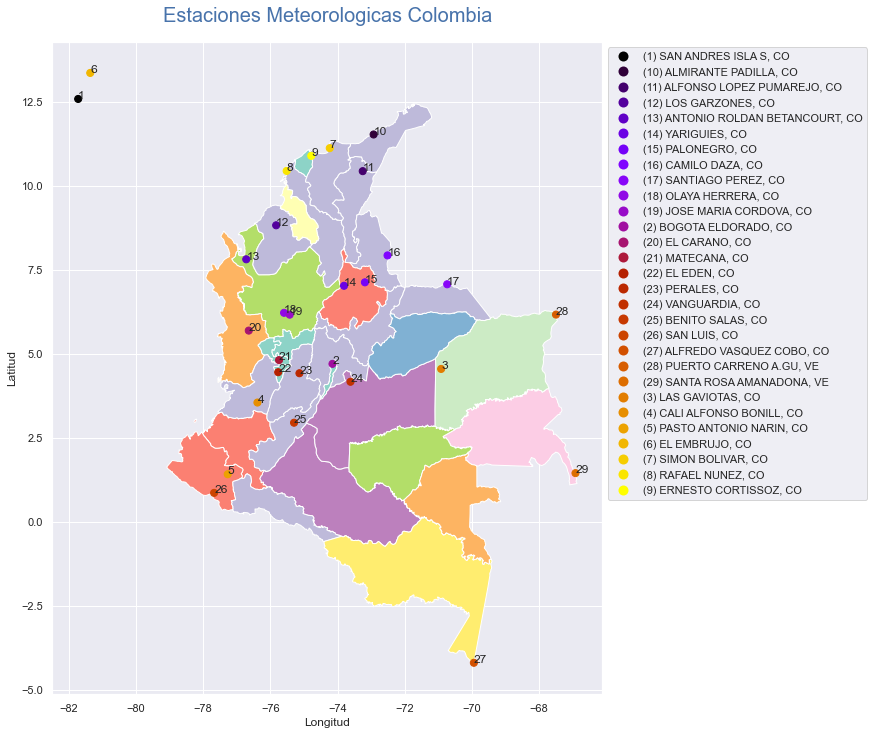

In [21]:
plot_estaciones_colombia(data)

### Precipitación

In [22]:
data.groupby('STATION').apply(describir_variables,'PRCP')

,Nombre,Días con datos,Días con datos vacios,Minimo,Maximo,Promedio,Desviacion
STATION,,,,,,,
CO000080001,"SAN ANDRES ISLA S, CO",8511,2408,0.0,13.11,0.190706,0.540757
CO000080222,"BOGOTA ELDORADO, CO",8173,2896,0.0,17.02,0.105306,0.367837
CO000080241,"LAS GAVIOTAS, CO",3520,40,0.0,5.35,0.301156,0.598683
CO000080259,"CALI ALFONSO BONILL, CO",6650,4056,0.0,7.48,0.098469,0.324288
CO000080342,"PASTO ANTONIO NARIN, CO",6947,1800,0.0,6.50,0.154126,0.394633
COM00080002,"EL EMBRUJO, CO",2614,1395,0.0,5.86,0.156595,0.440392
COM00080009,"SIMON BOLIVAR, CO",3836,4898,0.0,9.21,0.098298,0.422578
COM00080022,"RAFAEL NUNEZ, CO",5600,4919,0.0,15.41,0.154220,0.548306
COM00080028,"ERNESTO CORTISSOZ, CO",5803,5156,0.0,13.23,0.107033,0.468876


### Temperatura promedio

In [23]:
data.groupby('STATION').apply(describir_variables,'TAVG')

,Nombre,Días con datos,Días con datos vacios,Minimo,Maximo,Promedio,Desviacion
STATION,,,,,,,
CO000080001,"SAN ANDRES ISLA S, CO",10759,160,76.0,88.0,82.190073,1.616410
CO000080222,"BOGOTA ELDORADO, CO",10975,94,43.0,67.0,56.381139,1.906859
CO000080241,"LAS GAVIOTAS, CO",285,3275,72.0,91.0,81.957895,3.434239
CO000080259,"CALI ALFONSO BONILL, CO",10592,114,66.0,87.0,74.702417,2.180722
CO000080342,"PASTO ANTONIO NARIN, CO",5373,3374,59.0,79.0,68.334822,3.118790
COM00080002,"EL EMBRUJO, CO",4009,0,70.0,88.0,83.130456,1.907332
COM00080009,"SIMON BOLIVAR, CO",8734,0,73.0,94.0,84.906114,2.194197
COM00080022,"RAFAEL NUNEZ, CO",10519,0,75.0,91.0,82.421903,1.819210
COM00080028,"ERNESTO CORTISSOZ, CO",10959,0,75.0,91.0,81.957022,1.956750


### Temperatura máxima

In [24]:
data.groupby('STATION').apply(describir_variables,'TMAX')

,Nombre,Días con datos,Días con datos vacios,Minimo,Maximo,Promedio,Desviacion
STATION,,,,,,,
CO000080001,"SAN ANDRES ISLA S, CO",6868,4051,32.0,103.0,84.326878,9.723220
CO000080222,"BOGOTA ELDORADO, CO",6790,4279,32.0,85.0,67.454934,3.583561
CO000080241,"LAS GAVIOTAS, CO",3310,250,32.0,100.0,88.361934,5.077710
CO000080259,"CALI ALFONSO BONILL, CO",6013,4693,32.0,98.0,85.571429,8.511279
CO000080342,"PASTO ANTONIO NARIN, CO",3550,5197,32.0,87.0,73.267042,9.070695
COM00080002,"EL EMBRUJO, CO",1620,2389,81.0,104.0,86.977778,1.863336
COM00080009,"SIMON BOLIVAR, CO",3545,5189,84.0,110.0,92.405642,2.558166
COM00080022,"RAFAEL NUNEZ, CO",4495,6024,77.0,105.0,89.381313,2.229911
COM00080028,"ERNESTO CORTISSOZ, CO",4542,6417,82.0,106.0,91.785117,3.002175


### Temperatura mínima

In [25]:
data.groupby('STATION').apply(describir_variables,'TMIN')

,Nombre,Días con datos,Días con datos vacios,Minimo,Maximo,Promedio,Desviacion
STATION,,,,,,,
CO000080001,"SAN ANDRES ISLA S, CO",7916,3003,32.0,84.0,78.094618,4.659961
CO000080222,"BOGOTA ELDORADO, CO",7868,3201,20.0,55.0,46.771861,4.550208
CO000080241,"LAS GAVIOTAS, CO",3382,178,32.0,78.0,71.345653,3.337867
CO000080259,"CALI ALFONSO BONILL, CO",7186,3520,32.0,73.0,65.298636,5.087257
CO000080342,"PASTO ANTONIO NARIN, CO",7557,1190,32.0,68.0,58.096599,3.828086
COM00080002,"EL EMBRUJO, CO",2388,1621,68.0,84.0,77.935930,2.655724
COM00080009,"SIMON BOLIVAR, CO",6275,2459,56.0,83.0,75.979602,2.775622
COM00080022,"RAFAEL NUNEZ, CO",5309,5210,52.0,83.0,77.378979,2.366380
COM00080028,"ERNESTO CORTISSOZ, CO",5919,5040,51.0,82.0,75.918567,2.511842


## Visualización de los datos

In [26]:
estacion = obtener_datos_por_estacion(data,id_estacion='COM00080112')

### Comportamiento de las variables

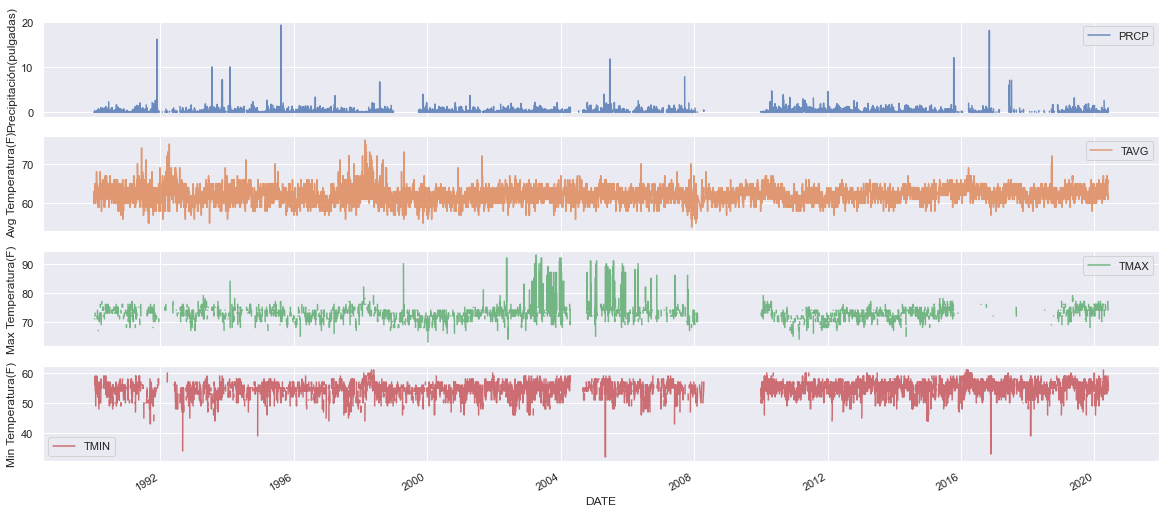

In [27]:
grafico_comportamiento_variables(estacion)

### Comportamiento variables por mes

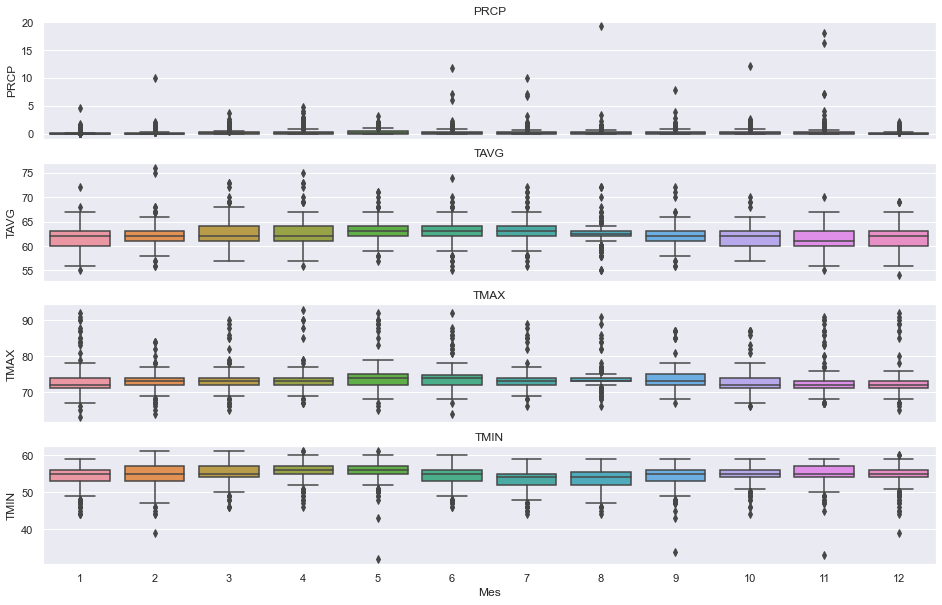

In [28]:
grafico_comportamiento_variables_por_mes(estacion)

### Datos estación filtrado por Variable y Fecha

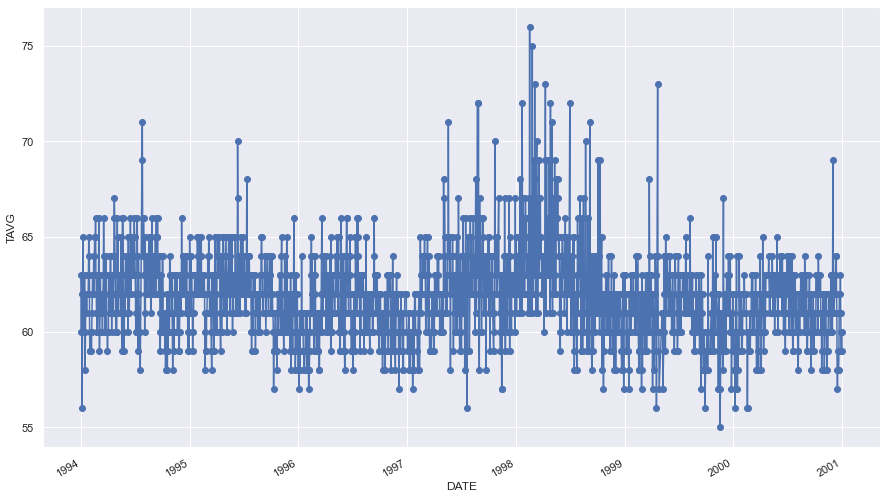

In [29]:
grafico_filtrado_fecha_variable(datos_estacion=estacion,fecha_min='1994-01',fecha_max='2000-12',variable='TAVG')

### Remuestreo de los datos filtrado por Variable y Fecha

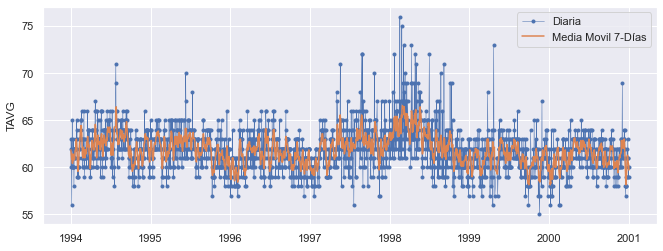

In [30]:
grafico_resampling_rolling_window(datos_estacion=estacion,fecha_min='1994-01',fecha_max='2000-12',variable='TAVG')